## Test the Quantum Annealing Simultation

### Test the DL-DFT neural network with the two magnetizations $\mathbf{x}$ and $\mathbf{z}$

Imports

In [13]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from src.training.models_adiabatic import Energy_XXZX

Data

In [14]:
data=np.load('data/kohm_sham_approach/disorder/reduction_2_input_channel_dataset_h_-2.7-2.7_omega_-2.7-2.7_j_1_1nn_n_150000.npz')

ndata=1000

z=data['density']
f=data['density_F']
h=data['potential']
e=data['energy']

z_torch=torch.from_numpy(z[:ndata])
f_torch=torch.from_numpy(f[:ndata])
h_torch=torch.from_numpy(h[:ndata])
e_torch=torch.from_numpy(e[:ndata])


print(h_torch.shape)
print(z_torch.shape)

model=torch.load('model_rep/kohm_sham/disorder/model_zzxz_reduction_2_input_channel_dataset_h_-2.7-2.7_omega_-2.7-2.7_j_1_1nn_150k_unet_l_train_8_[40, 40, 40, 40, 40, 40]_hc_5_ks_1_ps_6_nconv_0_nblock',map_location='cpu')
model.eval()



torch.Size([1000, 2, 8])
torch.Size([1000, 2, 8])


TDDFTadiabaticModel(
  (conv_downsample): ModuleList(
    (0): Sequential(
      (conv1): Conv1d(2, 40, kernel_size=(5,), stride=(1,), padding=(2,), padding_mode=circular)
      (activation 1): GELU()
    )
    (1): Sequential(
      (conv2): Conv1d(40, 40, kernel_size=(5,), stride=(1,), padding=(2,), padding_mode=circular)
      (activation 2): GELU()
    )
    (2): Sequential(
      (conv3): Conv1d(40, 40, kernel_size=(5,), stride=(1,), padding=(2,), padding_mode=circular)
      (activation 3): GELU()
    )
    (3): Sequential(
      (conv4): Conv1d(40, 40, kernel_size=(5,), stride=(1,), padding=(2,), padding_mode=circular)
      (activation 4): GELU()
    )
    (4): Sequential(
      (conv5): Conv1d(40, 40, kernel_size=(5,), stride=(1,), padding=(2,), padding_mode=circular)
      (activation 5): GELU()
    )
    (5): Sequential(
      (conv6): Conv1d(40, 40, kernel_size=(5,), stride=(1,), padding=(2,), padding_mode=circular)
      (activation_6): GELU()
    )
  )
  (conv_upsample): 

See the samples

The potential

In [ ]:
plt.hist(h[:,0],bins=200)
plt.show()

Magnetization $\mathbf{z}$

In [ ]:
for i in range(0,10):
    plt.plot(f[i,:])
    plt.plot(h[i,0,:])
    plt.show()

Test

Respect to z

In [15]:
z=z_torch[:,0,:]
z.requires_grad_(True)
print(z.shape)
input=torch.cat((z.unsqueeze(1),z_torch[:,1,:].unsqueeze(1)),dim=1)
f_ml=model(input)
f_ml.backward(torch.ones_like(f_ml))
print(z_torch[:,0,:].is_leaf)
df=torch.mean((f_ml-f_torch),dim=-1)
df_abs=torch.mean(torch.abs((f_ml-f_torch)),dim=-1)
print(df_abs.shape)
print(df_abs.mean())

torch.Size([1000, 8])
True
torch.Size([1000])
tensor(0.0006, dtype=torch.float64, grad_fn=<MeanBackward0>)


Visualization of $\mathbf{f}$

In [ ]:
for i in range(10):
    plt.plot(f_ml.detach().numpy()[i,:])
    plt.plot(f_torch.detach().numpy()[i,:])
    plt.show()

Gradient of $f_{ml}$

In [16]:
with torch.no_grad():
    grad = z.grad.clone()
    z.grad.zero_()

grad=grad

print(grad.shape)
print(h_torch.shape)


torch.Size([1000, 8])
torch.Size([1000, 2, 8])


The reconstruction of the field respect to $\mathbf{z}$

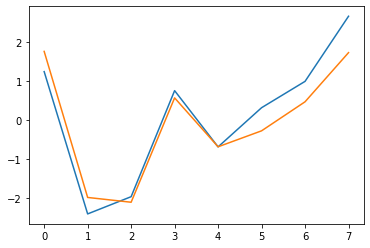

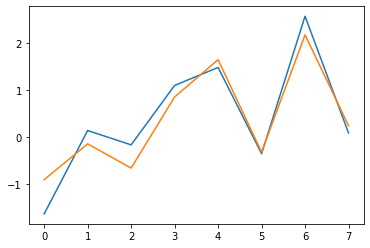

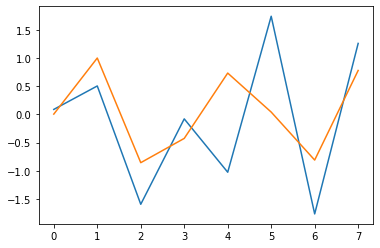

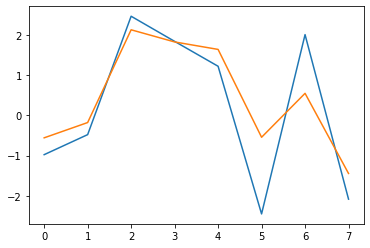

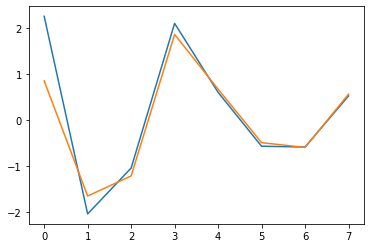

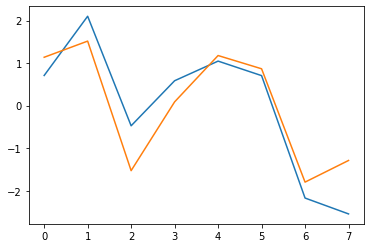

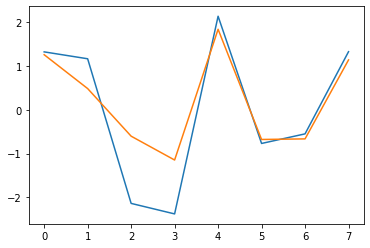

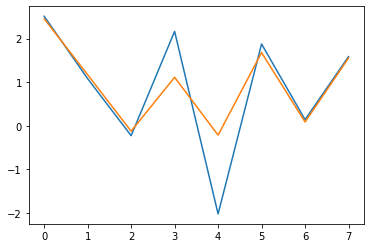

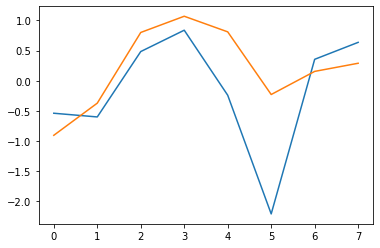

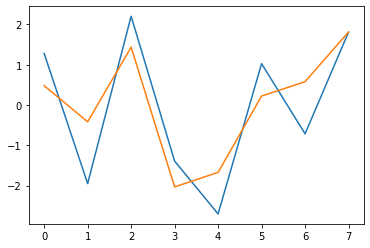

In [17]:
for i in range(10):
    plt.plot(h_torch[i,0,:].detach().numpy())
    plt.plot(-1*grad[i,:].detach().numpy())
    plt.show()

Respect to x

In [18]:
x=z_torch[:,1,:]
x.requires_grad_(True)
print(x.shape)
input=torch.cat((z_torch[:,0,:].unsqueeze(1),x.unsqueeze(1)),dim=1)
f_ml=model(input)
f_ml.backward(torch.ones_like(f_ml))
print(z_torch[:,0,:].is_leaf)
df=torch.mean((f_ml-f_torch),dim=-1)
df_abs=torch.mean(torch.abs((f_ml-f_torch)),dim=-1)
print(df_abs.shape)
print(df_abs.mean())

with torch.no_grad():
    grad = x.grad.clone()
    x.grad.zero_()

grad=grad

print(grad.shape)
print(h_torch.shape)

torch.Size([1000, 8])
True
torch.Size([1000])
tensor(0.0006, dtype=torch.float64, grad_fn=<MeanBackward0>)
torch.Size([1000, 8])
torch.Size([1000, 2, 8])


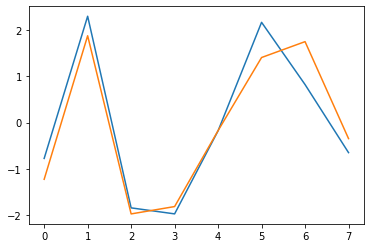

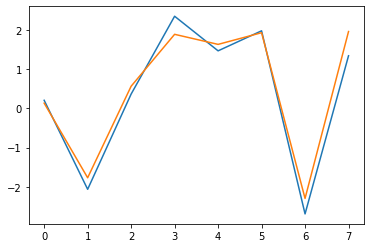

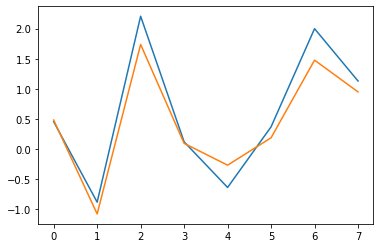

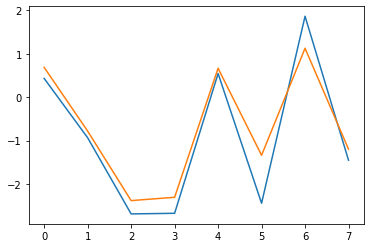

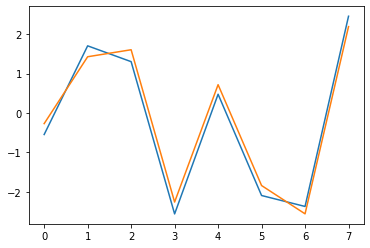

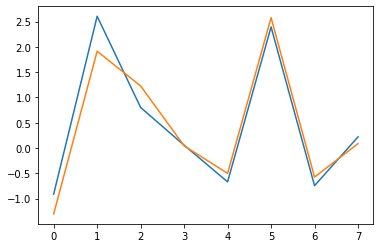

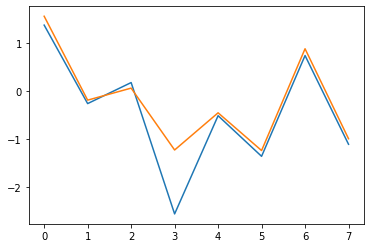

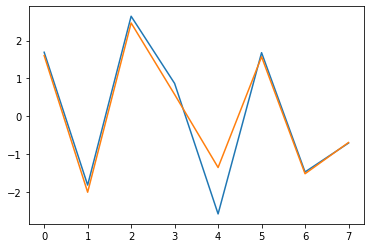

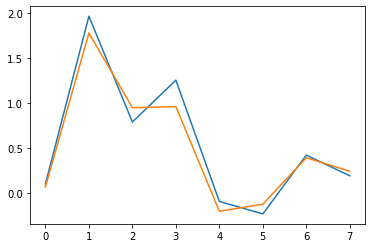

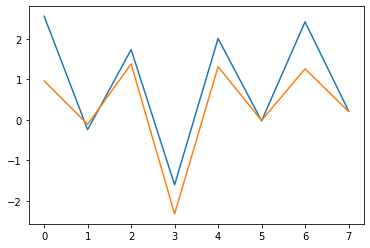

In [19]:
for i in range(10):
    plt.plot(h_torch[i,1,:].detach().numpy())
    plt.plot(-1*grad[i,:].detach().numpy())
    plt.show()

Visualization $\Delta \mathbf{f}$

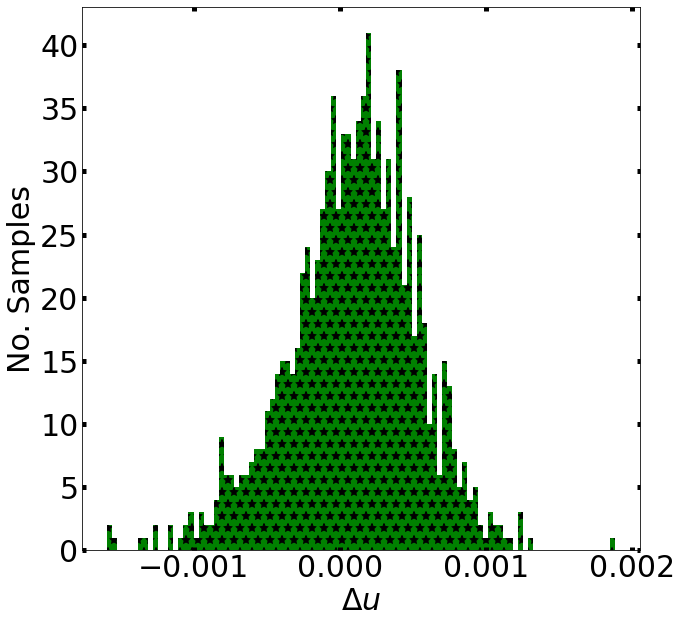

In [9]:
plt.figure(figsize=(10,10))
plt.hist(df.detach().numpy(),bins=100,color='green',hatch='*')
plt.xlabel(r'$\Delta u$',fontsize=30)
plt.ylabel(r'No. Samples',fontsize=30)
plt.tick_params(
        top=True,
        right=True,
        labeltop=False,
        labelright=False,
        direction="in",
        labelsize=30,
        width=5,
    )
plt.show()

#### Energy computation

In [21]:
z=z_torch[:,0,:].detach().unsqueeze(1)
x=z_torch[:,1,:].detach().unsqueeze(1)
z.requires_grad_(True)

input=torch.cat((z,x),dim=1)

energy=Energy_XXZX(model=model)

e_ml=energy(z=input,h=h_torch)
e_ml.backward(torch.ones_like(e_ml))


print(torch.mean(torch.abs(e_ml-e_torch)/torch.abs(e_torch)))

print(e_ml[0],e_torch[0])



tensor(0.0002, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(-17.6678, dtype=torch.float64, grad_fn=<SelectBackward0>) tensor(-17.6679, dtype=torch.float64)


#### Accuracy of the Gradient

In [25]:
# the gradient should be zero because we are in the ground state
with torch.no_grad():
    grad = z.grad.clone()
    z.grad.zero_()


In [30]:
print(grad[0,0])

tensor([ 0.8445,  0.3313,  2.4621,  0.8979,  1.3166,  0.0411,  0.1923, -0.2914],
       dtype=torch.float64)


Visualization, Part 1: $\mathbf{x}[\mathbf{z}]$

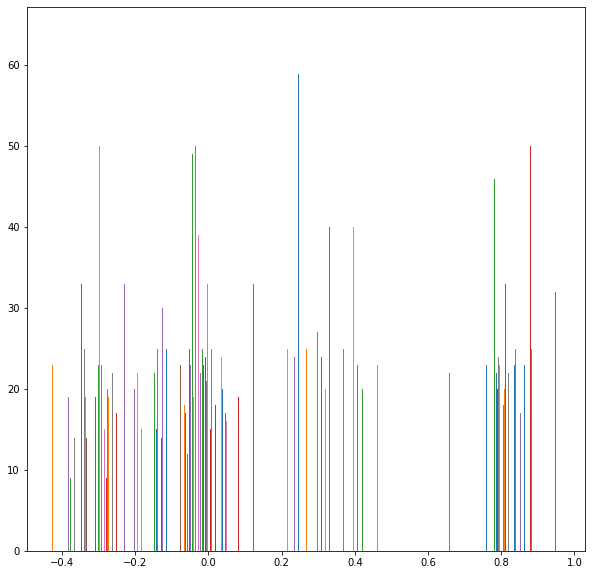

In [20]:
plt.figure(figsize=(10,10))
plt.hist(f_ml[:,0].detach().numpy(),bins=200)
plt.show()

### Test the DL-DFT neural network with the two magnetizations $\mathbf{z}$

Imports

In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from src.training.models_adiabatic import Energy_XXZX_1input

Data

In [5]:
data=np.load('data/kohm_sham_approach/disorder/reduction_1_input_channel_dataset_h_2.7_costant_omega_1.0_j_1_1nn_n_150000.npz')

ndata=1000

z=data['density']
f=data['density_F']
h=data['potential']
e=data['energy']

z_torch=torch.from_numpy(z[:ndata])
f_torch=torch.from_numpy(f[:ndata])
h_torch=torch.from_numpy(h[:ndata])
e_torch=torch.from_numpy(e[:ndata])


model=torch.load('model_rep/kohm_sham/disorder/model_zzxz_reduction_1_input_channel_f_h_2.7_constant_omega_1.0_j_1_1nn_150k_unet_l_train_8_[40, 40, 40, 40, 40, 40]_hc_5_ks_1_ps_6_nconv_0_nblock',map_location='cpu')
model.eval()



TDDFTadiabaticModel(
  (conv_downsample): ModuleList(
    (0): Sequential(
      (conv1): Conv1d(2, 40, kernel_size=(5,), stride=(1,), padding=(2,), padding_mode=circular)
      (activation 1): GELU()
    )
    (1): Sequential(
      (conv2): Conv1d(40, 40, kernel_size=(5,), stride=(1,), padding=(2,), padding_mode=circular)
      (activation 2): GELU()
    )
    (2): Sequential(
      (conv3): Conv1d(40, 40, kernel_size=(5,), stride=(1,), padding=(2,), padding_mode=circular)
      (activation 3): GELU()
    )
    (3): Sequential(
      (conv4): Conv1d(40, 40, kernel_size=(5,), stride=(1,), padding=(2,), padding_mode=circular)
      (activation 4): GELU()
    )
    (4): Sequential(
      (conv5): Conv1d(40, 40, kernel_size=(5,), stride=(1,), padding=(2,), padding_mode=circular)
      (activation 5): GELU()
    )
    (5): Sequential(
      (conv6): Conv1d(40, 40, kernel_size=(5,), stride=(1,), padding=(2,), padding_mode=circular)
      (activation_6): GELU()
    )
  )
  (conv_upsample): 

See the samples

Magnetization $\mathbf{z}$

In [ ]:
for i in range(0,10):
    plt.plot(f[i,:])
    plt.plot(h[i,0,:])
    plt.show()

Test

Respect to z

In [6]:
z_torch.requires_grad_(True)
f_ml=model(z_torch)
print('z shape=',z_torch.shape)
f_sum=f_ml.sum(-1)
f_sum=f_sum.view(-1)

print(f_sum.shape)
f_sum.backward(torch.ones_like(f_sum))

df=torch.mean((f_ml-f_torch),dim=-1)
df_abs=torch.mean(torch.abs((f_ml-f_torch)),dim=-1)
print(df_abs.shape)
print(df_abs[:,1].mean())

IndexError: tuple index out of range

Visualization of $\mathbf{f}$

In [ ]:
for i in range(10):
    plt.plot(f_ml.detach().numpy()[i,1,:])
    plt.plot(f_torch.detach().numpy()[i,1,:])
    plt.show()

Gradient of $f_{ml}$

In [37]:
with torch.no_grad():
    grad = z_torch.grad.clone()
    z_torch.grad.zero_()
print(grad.shape)
grad=grad

print(grad.shape)



torch.Size([1000, 8])
torch.Size([1000, 8])


The reconstruction of the field respect to $\mathbf{z}$

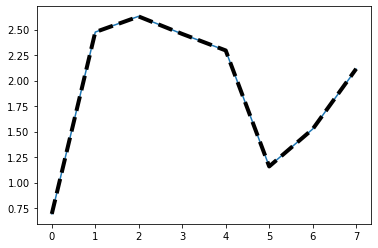

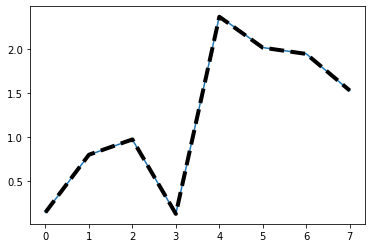

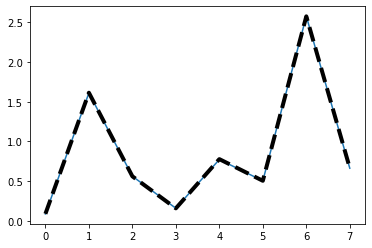

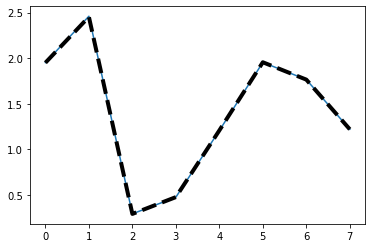

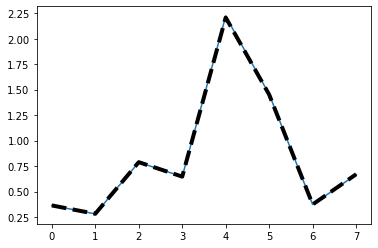

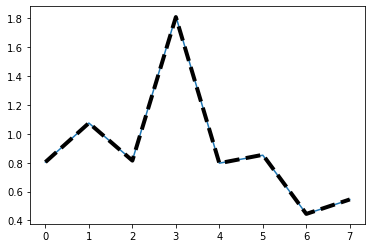

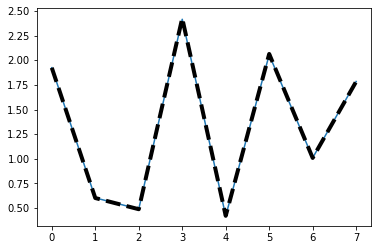

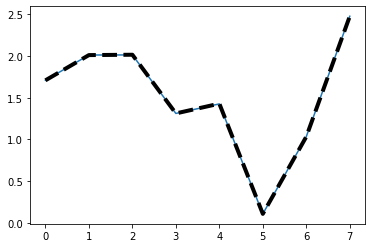

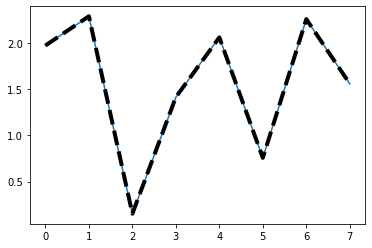

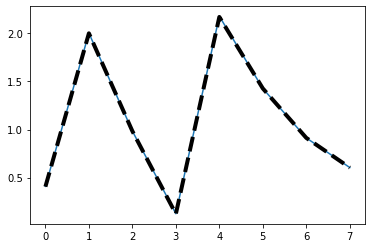

In [35]:
for i in range(10):
    plt.plot(h_torch[i,0,:].detach().numpy())
    plt.plot(-1*grad[i,:].detach().numpy(),color='black',linestyle='--',linewidth=4)
    plt.show()

torch.Size([1000, 8])


Check if $\frac{\delta F}{\delta z_i}=\frac{\sum_j \delta x_j}{\delta z_i}$

In [23]:
for i in range(10):
    plt.plot(-1*grad[i,1,:].detach().numpy(),color='red',linewidth=2)
    plt.plot(-1*grad[i,0,:].detach().numpy(),color='black',linestyle='--',linewidth=4)
    plt.show()

IndexError: too many indices for tensor of dimension 2

Computing the Jacobian $\frac{\delta x_i}{\delta z_j}$

In [12]:
z_torch.requires_grad_(True)

f=model(z_torch)

l=z_torch.shape[-1]
for i in range(l):
    grad_z_x=torch.autograd.grad(f[0,1,i],z_torch,retain_graph=True)
    print(grad_z_x[0].shape)
    if i==0:
        matrix_z_x=grad_z_x[0].clone().detach().unsqueeze(-2)       
    else:
        matrix_z_x=torch.cat((matrix_z_x,grad_z_x[0].clone().detach().unsqueeze(-2)),dim=-2)
        
print(matrix_z_x.shape)

print(matrix_z_x[0,:,:])



torch.Size([1000, 8])
torch.Size([1000, 8])
torch.Size([1000, 8])
torch.Size([1000, 8])
torch.Size([1000, 8])
torch.Size([1000, 8])
torch.Size([1000, 8])
torch.Size([1000, 8])
torch.Size([1000, 8, 8])
tensor([[ 9.7532e-01,  1.4404e-01,  1.0990e-03, -9.5779e-05,  4.1415e-04,
          1.7106e-04,  2.8416e-03,  1.6087e-01],
        [-3.4683e-02, -1.9267e+00,  1.8991e-02, -6.5322e-05,  1.1053e-06,
          3.6395e-04,  5.5058e-04,  6.3852e-03],
        [-8.6400e-04,  3.7763e-02, -8.7086e-01,  5.4415e-02,  2.2380e-03,
          1.5025e-04, -5.5609e-05,  6.1792e-04],
        [ 4.1199e-05,  9.6883e-04,  5.9454e-02, -7.3713e-01,  6.1981e-02,
          1.4492e-03,  7.8983e-05,  1.8047e-04],
        [ 1.6140e-04, -4.6769e-04,  7.9837e-04,  4.1080e-02, -9.8105e-01,
          4.0618e-02,  7.4244e-03,  1.4518e-03],
        [-3.9986e-04,  6.7819e-04,  3.5665e-04,  3.2508e-03,  1.4892e-01,
          1.5080e-01,  1.3400e-01,  1.1244e-02],
        [-1.4114e-03, -7.7259e-04, -3.0320e-04,  7.0706e-04, 

Compute the quantity $\frac{\delta F}{\delta x_i}= \frac{\delta z_j}{\delta x_i}\frac{\delta F}{\delta z_j}$

In [13]:
inv_matrix_z_x=torch.linalg.inv(matrix_z_x[0,:,:])
print(inv_matrix_z_x)

grad_x=torch.einsum('ji,j->i',inv_matrix_z_x,grad[0,:])
print(grad_x)

tensor([[ 1.0326e+00,  7.7759e-02,  2.9980e-03,  7.9693e-05, -1.7614e-04,
         -6.9726e-03,  1.3961e-02,  1.0114e-01],
        [-1.8696e-02, -5.2066e-01, -1.1430e-02, -7.8293e-04,  1.2851e-04,
          1.5365e-03, -6.9885e-04, -3.8471e-03],
        [-1.8536e-03, -2.2813e-02, -1.1546e+00, -8.5633e-02, -7.4703e-03,
          3.5644e-03,  1.3681e-03, -6.2771e-04],
        [-5.2617e-05, -2.4957e-03, -9.3509e-02, -1.3679e+00, -8.1597e-02,
          3.1421e-02,  1.0766e-02,  4.3433e-04],
        [ 5.6701e-04,  2.4103e-04, -4.5171e-03, -5.4077e-02, -9.8459e-01,
          2.3886e-01,  7.6044e-02,  4.2761e-03],
        [ 1.2028e-02,  2.6402e-03,  7.7027e-03,  7.7966e-02,  9.0774e-01,
          5.5666e+00,  2.3190e+00,  1.4557e-01],
        [-8.7072e-03,  1.7778e-04,  1.7717e-03,  5.7774e-03,  7.4549e-02,
          9.3043e-01, -2.6912e+00, -1.1725e-01],
        [-2.7132e-02, -5.1066e-03, -1.3799e-04, -5.7319e-05,  1.2080e-03,
          1.7923e-02, -3.9142e-02, -6.0782e-01]], dtype=torch.flo

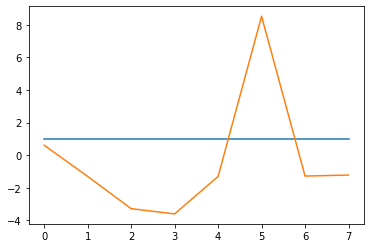

In [14]:
plt.plot(h_torch[0,1,:].detach().numpy())
plt.plot(-1*grad_x.detach().numpy())
plt.show()

Visualization $\Delta \mathbf{f}$

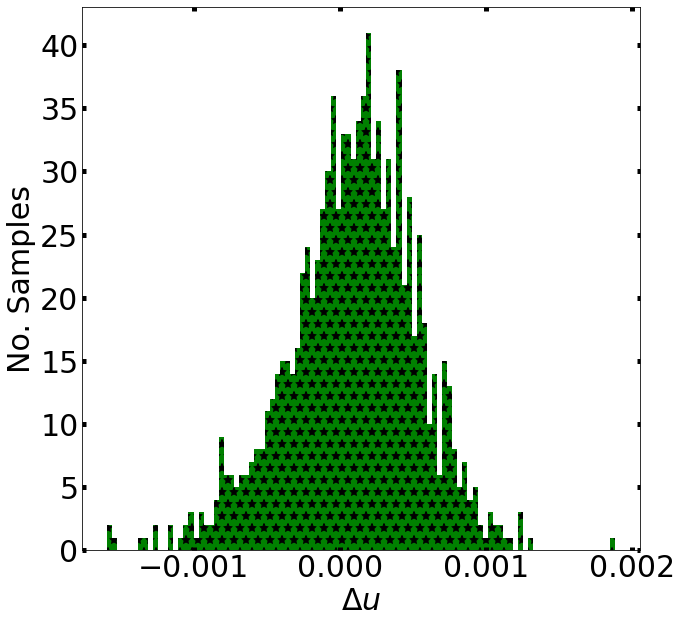

In [ ]:
plt.figure(figsize=(10,10))
plt.hist(df.detach().numpy(),bins=100,color='green',hatch='*')
plt.xlabel(r'$\Delta u$',fontsize=30)
plt.ylabel(r'No. Samples',fontsize=30)
plt.tick_params(
        top=True,
        right=True,
        labeltop=False,
        labelright=False,
        direction="in",
        labelsize=30,
        width=5,
    )
plt.show()

#### Energy computation

In [ ]:
z=z_torch[:,0,:].detach().unsqueeze(1)
x=z_torch[:,1,:].detach().unsqueeze(1)
z.requires_grad_(True)

input=torch.cat((z,x),dim=1)

energy=Energy_XXZX(model=model)

e_ml=energy(z=input,h=h_torch)
e_ml.backward(torch.ones_like(e_ml))


print(torch.mean(torch.abs(e_ml-e_torch)/torch.abs(e_torch)))

print(e_ml[0],e_torch[0])



tensor(0.0002, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(-17.6678, dtype=torch.float64, grad_fn=<SelectBackward0>) tensor(-17.6679, dtype=torch.float64)


#### Accuracy of the Gradient

In [ ]:
# the gradient should be zero because we are in the ground state
with torch.no_grad():
    grad = z.grad.clone()
    z.grad.zero_()


In [ ]:
print(grad[0,0])

tensor([ 0.8445,  0.3313,  2.4621,  0.8979,  1.3166,  0.0411,  0.1923, -0.2914],
       dtype=torch.float64)


Visualization, Part 1: $\mathbf{x}[\mathbf{z}]$

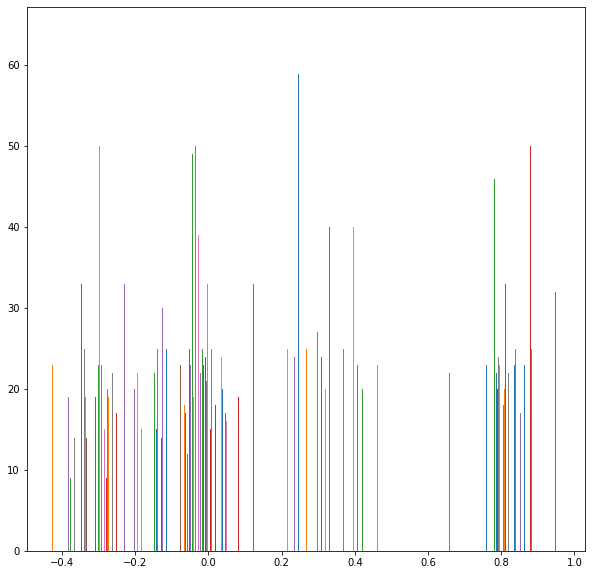

In [ ]:
plt.figure(figsize=(10,10))
plt.hist(f_ml[:,0].detach().numpy(),bins=200)
plt.show()

#### Check the DL-DFT Model in the Qutip Dataset of disorder Configurations

Imports

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from typing import List
from src.training.models_adiabatic import Energy_XXZX

Data

In [ ]:
data=np.load('data/disorder/test_for_adiabatic_size_8_tf_10.0_dt_0.01_rate_1.0_h_2.7_n_dataset_10.npz')

ndata=1000

z=data['density']
h=data['potential']
time=data['time']

z_torch=torch.from_numpy(z[:ndata])
h_torch=torch.from_numpy(h[:ndata])
print(z_torch.shape)

model=torch.load('model_rep/kohm_sham/model_zzxz_reduction_150k_unet_l_train_8_[40, 40, 40, 40, 40, 40]_hc_5_ks_1_ps_6_nconv_0_nblock',map_location='cpu')
model.eval()

energy=Energy_XXZX(model=model)


torch.Size([10, 1000, 8])


Test of the energy functional over the evolution configurations $\mathbf{z}(t)$

In [ ]:
emls:List[np.ndarray]=[]

#sample
for i in range(z_torch.shape[0]):
    e_ml=energy(z_torch[i],h_torch[i])
    emls.append(e_ml.detach().numpy())

Visualization

In [ ]:
for e in emls:
    plt.plot(time,e)
    plt.xlabel(r'$t [1/J]$')
    plt.ylabel(r'$e_{ml}(t)$')
    plt.show()

Functional derivative of $\braket{\hat{Z}_i \hat{Z}_{i+1}}=f_i$ over the evolution configuration $\mathbf{z}(t)$

In [ ]:
grads:List[np.ndarray]=[]

z_torch.requires_grad_(False)

for i in range(z_torch.shape[0]):
    phi=z_torch[i]
    phi.requires_grad_(True)
    f=model(phi).mean(-1)[:,0]
    print(f.shape)
    f.backward(torch.ones_like(f))
    print(phi.requires_grad)
    with torch.no_grad():
            grad = phi.grad.clone()
            print(grad.shape)
            grads.append(grad.detach().numpy())
            phi.grad.zero_()
            



Visualization

(1000, 8)


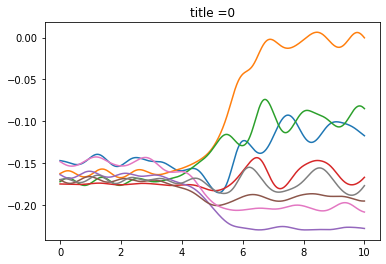

(1000, 8)


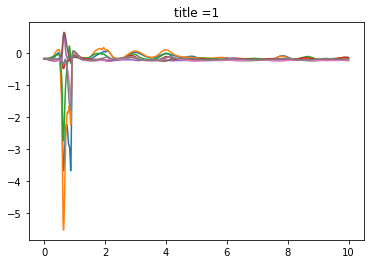

(1000, 8)


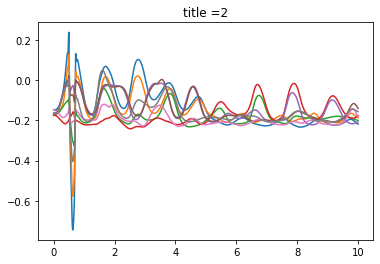

(1000, 8)


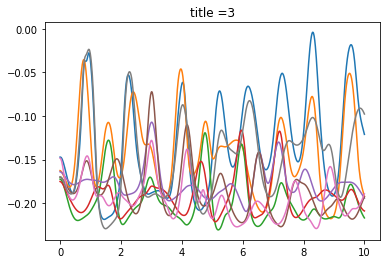

(1000, 8)


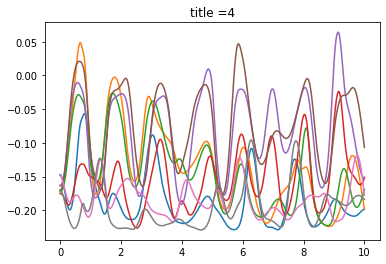

(1000, 8)


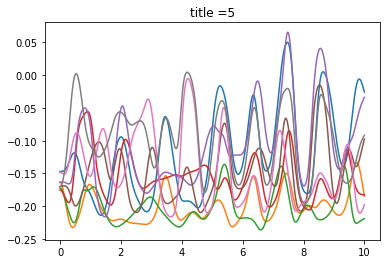

(1000, 8)


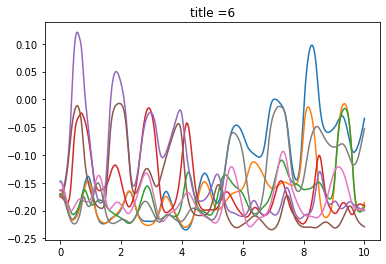

(1000, 8)


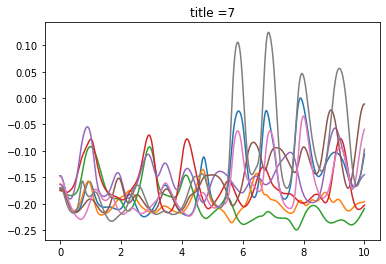

(1000, 8)


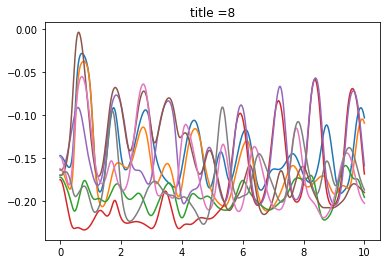

(1000, 8)


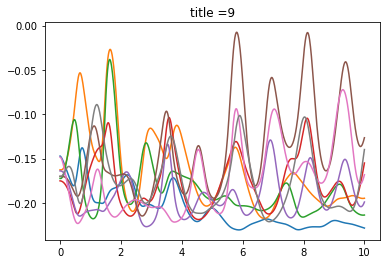

In [ ]:
for i,grad in enumerate(grads):
    plt.title(f'title ={i}')
    print(grad.shape)
    plt.plot(time,grad)
    plt.show()

This study check the stability of the DL-DFT method tested on possible time evolution samples like $\mathbf{z}(t)$. This is the starting point to apply the Crank-Nicholson algorithm